In [8]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
import torch
from pymatgen.core import Structure
from IPython.display import display

# Minimal imports from your modules (adjust paths as needed):
from bin.evaluate import load_model_from_checkpoint
from bin.train import TrainConfig
from decifer.tokenizer import Tokenizer
from decifer.utility import (
    pxrd_from_cif,
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop
)
import crystal_toolkit

from ase.visualize.plot import plot_atoms
from ase.data import colors, atomic_numbers

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure as PMGStructure
from pymatgen.io.ase import AseAtomsAdaptor

# Define the periodic table layout (rows of 18 cells; use None for blank cells)
periodic_table_layout = [
    # Period 1
    ["H", None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, "He"],
    # Period 2
    ["Li", "Be", None, None, None, None, None, None, None, None, None, None, "B", "C", "N", "O", "F", "Ne"],
    # Period 3
    ["Na", "Mg", None, None, None, None, None, None, None, None, None, None, "Al", "Si", "P", "S", "Cl", "Ar"],
    # Period 4
    ["K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr"],
    # Period 5
    ["Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe"],
    # Period 6 Main Block
    ["Cs", "Ba", "La", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", None],
    # Period 7 Main Block
    ["Fr", "Ra", "Ac", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og", None],
    # Break
    [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    # Lanthanides (Period 6)
    [None, None, None, "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", None],
    # Actinides (Period 7)
    [None, None, None, "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", None]
]

# Build a list of all unique element symbols (default: all are selected)
global_inactive_elements_list = []
for row in periodic_table_layout:
    for el in row:
        if el is not None:
            global_inactive_elements_list.append(el)

TOKENIZER = Tokenizer()
VOCAB_SIZE = TOKENIZER.vocab_size
START_ID = TOKENIZER.token_to_id["data_"]
PADDING_ID = TOKENIZER.padding_id
NEWLINE_ID = TOKENIZER.token_to_id["\n"]
SPACEGROUP_ID = TOKENIZER.token_to_id["_symmetry_space_group_name_H-M"]
DECODE = TOKENIZER.decode
ENCODE = TOKENIZER.encode
TOKENIZE = TOKENIZER.tokenize_cif

def read_experimental_data(zip_path):
    """
    Reads and combines all .xy or .xye files in the zip,
    maps them to their compositions, returns a single DataFrame.
    """
    # Read Jens composition Excel
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open('experimental_data/Jens/Compositions.xlsx') as f:
            df_jens_comp = pd.read_excel(f, engine='openpyxl')
    df_jens_comp['Name_lower'] = df_jens_comp['Name'].str.lower()
    
    def get_jens_composition(fname):
        fname_lower = fname.lower()
        for _, row in df_jens_comp.iterrows():
            if row['Name_lower'] in fname_lower:
                return row['Composition']
        return None
    
    frames = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        for info in z.infolist():
            if info.is_dir():
                continue
            fn = info.filename
            if not (fn.endswith('.xy') or fn.endswith('.xye')):
                continue
            
            with z.open(fn) as f:
                lines = f.read().decode('utf-8').splitlines()
            
            folder = os.path.basename(os.path.dirname(fn))
            base_name = os.path.basename(fn)
            # Infer composition
            if folder.lower() == 'jens':
                comp_str = get_jens_composition(base_name)
            elif folder.lower() == 'laura_irox':
                if 'irox' in base_name.lower():
                    comp_str = 'IrOx'
                elif 'iro2' in base_name.lower():
                    comp_str = 'IrO2'
                else:
                    comp_str = 'Ir-based oxide'
            elif folder.lower() == 'nicolas':
                subfolder = fn.split('/')[-2]
                if 'fcc pure' in subfolder.lower():
                    comp_str = 'Pt (fcc)'
                elif 'fcc+fct' in subfolder.lower():
                    comp_str = 'Pt (fcc+fct)'
                else:
                    comp_str = 'Pt-based'
            elif folder.lower() == 'rebecca_ceo2':
                comp_str = 'CeO2'
            else:
                comp_str = None

            records = []
            for line in lines:
                parts = line.split()
                if len(parts) == 2:
                    angle, intensity = parts
                    records.append((float(angle), float(intensity), None))
                elif len(parts) == 3:
                    angle, intensity, error = parts
                    records.append((float(angle), float(intensity), float(error)))

            df_temp = pd.DataFrame(records, columns=['angle', 'intensity', 'error'])
            df_temp['composition'] = comp_str
            df_temp['source_file'] = base_name
            df_temp['source_folder'] = folder
            frames.append(df_temp)

    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

def standardize_signal(df, q_col, intensity_col, q_min=0.0, q_max=10.0, n_points=1000):
    df = df.drop_duplicates(subset=q_col).sort_values(by=q_col)
    q_new = np.linspace(q_min, q_max, n_points)
    i_new = np.interp(q_new, df[q_col], df[intensity_col])
    return pd.DataFrame({q_col: q_new, intensity_col: i_new})

def load_custom_model(model_path, device="cuda"):
    return load_model_from_checkpoint(model_path, device=device)

def fix_symmetry_in_cif(cif_string):
    c = replace_symmetry_loop_with_P1(cif_string)
    sg = extract_space_group_symbol(c)
    return reinstate_symmetry_loop(c, sg) if sg != "P 1" else c

def generate_cif(model, cond_vec, composition=None, spacegroup=None, max_new_tokens=3000, exclusive_elements=None, temperature=1.0,
                crystal_systems=None):

    if exclusive_elements is not None:
        inactive_elements_list = [el for el in global_inactive_elements_list if el not in exclusive_elements]
    else:
        inactive_elements_list = None

    if crystal_systems is not None:
        active_spacegroups = []
        for cs in crystal_systems:
            active_spacegroups.extend(get_space_group_symbols_for_crystal_system(cs))
    else:
        active_spacegroups = None

    # print(active_spacegroups)
    
    prompt = torch.tensor([START_ID]).unsqueeze(0).to(model.device)
    if composition:
        comp_str = f"data_{composition}\n"
        c_tokens = ENCODE(TOKENIZE(comp_str))
        prompt = torch.tensor(c_tokens).unsqueeze(0).to(model.device)
    out = model.generate_custom(
        idx=prompt,
        max_new_tokens=max_new_tokens,
        cond_vec=cond_vec,
        start_indices_batch=[[0]],
        composition_string=composition,
        spacegroup_string=spacegroup,
        exclude_elements = inactive_elements_list,
        temperature=temperature,
        disable_pbar=False,
        include_spacegroups=active_spacegroups,
    ).cpu().numpy()
    return DECODE(out[0])

def run_decifer_generation(model, cond_array, composition=None, spacegroup=None, do_plot=False, q_exp=None, i_exp=None, 
                           exclusive_elements=None, temperature=1.0, wavelength='CuKa', size_estimate=None, max_new_tokens=3000,
                           crystal_systems=None):
    device = model.device
    if not isinstance(cond_array, torch.Tensor):
        cond_array = torch.tensor(cond_array)
    cond_array = cond_array.unsqueeze(0).to(model.device).float()

    cif_raw = generate_cif(model, cond_vec=cond_array, composition=composition, spacegroup=spacegroup, 
                           exclusive_elements=exclusive_elements, temperature=temperature, max_new_tokens=max_new_tokens,
                           crystal_systems=crystal_systems)
    try:
        cif_fixed = fix_symmetry_in_cif(cif_raw)
        structure = Structure.from_str(cif_fixed, fmt="cif")
        pxrd_dict = pxrd_from_cif(cif_fixed, base_fwhm=0.0125, wavelength=wavelength, particle_size=size_estimate)
        return cif_fixed, structure, pxrd_dict
    except Exception as e:
        print(e)
        return None

def preprocess_generic(df, target_file, 
                       wavelength=0.25448, q_min_crop=1.0, q_max_crop=8.0,
                       n_points=1000, background_file=None):
    """
    Process a sample file (and an optional background file) and return a single DataFrame
    containing all transformations, interpolated on a common Q grid.

    Transformations performed:
      1. Filter for the target file and compute Q.
      2. (Optional) Subtract background – the background is scaled maximally so that at no Q does 
         the scaled background exceed the sample intensity.
      3. Normalize the full (background‐subtracted) signal.
      4. Crop the signal (q_min_crop to q_max_crop), compute a baseline from the cropped region,
         subtract it (excluding endpoints), and then add endpoints (Q=0 and Q=10 with zero intensity).
      5. Normalize the cropped, baseline‐corrected signal.
      6. Standardize all signals onto a uniform Q grid (0 to 10, n_points samples) and store results.
      7. (Optional) Include the background and scaled background signals in the output.
    """
    # ----- 1. Filter for sample and compute Q -----
    df_sel = df[df['source_file'].str.lower() == target_file.lower()].copy()
    theta_rad = np.radians(df_sel["angle"] / 2.0)
    df_sel["Q"] = (4.0 * np.pi / wavelength) * np.sin(theta_rad)

    # ----- 2. Background subtraction with scaling -----
    if background_file is not None:
        bg_df = df[df['source_file'].str.lower() == background_file.lower()].copy()
        theta_rad_bg = np.radians(bg_df["angle"] / 2.0)
        bg_df["Q"] = (4.0 * np.pi / wavelength) * np.sin(theta_rad_bg)
        bg_df.sort_values(by="Q", inplace=True)
        # Interpolate the background intensity onto the sample's Q values.
        df_sel["background_intensity"] = np.interp(df_sel["Q"], bg_df["Q"], bg_df["intensity"])
        # Compute scaling factor: maximum s such that for every point with background > 0,
        # s * background_intensity <= sample intensity.
        valid = df_sel["background_intensity"] > 0
        if valid.any():
            s = (df_sel.loc[valid, "intensity"] / df_sel.loc[valid, "background_intensity"]).min()
        else:
            s = 1.0
        df_sel["scaled_background"] = s * df_sel["background_intensity"]
        # Subtract the scaled background.
        df_sel["intensity_bg"] = df_sel["intensity"] - df_sel["scaled_background"]
    else:
        df_sel["intensity_bg"] = df_sel["intensity"]

    # ----- 3. Full signal normalization -----
    maxI = df_sel["intensity_bg"].max(skipna=True)
    df_sel["intensity_norm"] = df_sel["intensity_bg"] / maxI

    # ----- 4. Crop for baseline correction -----
    df_crop_orig = df_sel[(df_sel["Q"] >= q_min_crop) & (df_sel["Q"] <= q_max_crop)].copy()
    baseline = df_crop_orig["intensity_bg"].min(skipna=True)
    df_crop_orig["intensity_corrected"] = df_crop_orig["intensity_bg"] - baseline
    # Add endpoints so that the Q range spans 0 to 10.
    df_endpoints = pd.DataFrame({"Q": [0.0, 10.0], "intensity_corrected": [0, 0]})
    df_crop = pd.concat([df_crop_orig[["Q", "intensity_corrected"]], df_endpoints], ignore_index=True)
    df_crop.sort_values(by="Q", inplace=True)

    # ----- 5. Normalize the cropped, baseline-corrected signal -----
    max_val = df_crop_orig["intensity_corrected"].max(skipna=True)
    df_crop["intensity_normalized"] = df_crop["intensity_corrected"] / max_val

    # ----- 6. Standardize signals onto a common Q grid -----
    Q_std = np.linspace(0, 10, n_points)
    df_final = pd.DataFrame({"Q": Q_std})
    df_final["intensity_original"] = np.interp(Q_std, df_sel["Q"], df_sel["intensity"])
    df_final["intensity_bg_subtracted"] = np.interp(Q_std, df_sel["Q"], df_sel["intensity_bg"])
    df_final["intensity_norm"] = np.interp(Q_std, df_sel["Q"], df_sel["intensity_norm"])
    df_final["intensity_crop_norm"] = np.interp(Q_std, df_crop["Q"], df_crop["intensity_normalized"])

    # ----- 7. Include background signals in the output (if provided) -----
    if background_file is not None:
        df_final["intensity_bg"] = np.interp(Q_std, df_sel["Q"], df_sel["background_intensity"])
        df_final["intensity_scaled_bg"] = np.interp(Q_std, df_sel["Q"], df_sel["scaled_background"])
    return df_final

def plot_unit_cell_with_boundaries(structure, ax=None, tol=1e-5, radii=0.8, rotation=('45x, -15y, 90z'), offset=(0, 0, 0)):
    """
    Plots the unit cell along with image atoms from neighboring cells (in the positive x, y, and z directions)
    that are exactly on the unit cell boundary onto a provided axis.
    
    Parameters:
        structure (pymatgen.core.structure.Structure): The input structure.
        ax (matplotlib.axes.Axes): Axis to plot on. If None, a new axis is created.
        tol (float): Tolerance for determining if an atom's fractional coordinate is on the boundary.
        radii (float): Radii for visualizing atoms.
        rotation (tuple or str): Rotation settings for the plot_atoms function.
        
    Returns:
        (ax, discrete_structure): The matplotlib axis containing the plotted structure 
            and the discrete pymatgen Structure constructed.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Define translation vectors for the original cell and its neighboring cells in the positive directions.
    translation_vectors = [
        [0, 0, 0],  # Original cell
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1]
    ]
    
    all_species = []
    all_coords = []
    
    # Loop over each translation vector.
    for tv in translation_vectors:
        tv_cart = structure.lattice.get_cartesian_coords(tv)
        for site in structure:
            if tv == [0, 0, 0]:
                # For the original cell, include all atoms.
                all_species.append(site.species_string)
                all_coords.append(site.coords)
            else:
                # For neighboring cells, include only atoms on the cell boundary
                # (i.e. the atom's fractional coordinate is nearly zero in each shifted direction).
                if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                    all_species.append(site.species_string)
                    all_coords.append(site.coords + tv_cart)
    
    discrete_structure = PMGStructure(
        lattice=structure.lattice.matrix,
        species=all_species,
        coords=np.array(all_coords),
        coords_are_cartesian=True
    )
    
    # Convert the discrete pymatgen structure to an ASE Atoms object and remove periodic boundaries.
    ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
    ase_atoms.set_pbc([False, False, False])
    
    # Plot onto the provided axis.
    plot_atoms(ase_atoms, ax, radii=radii, show_unit_cell=True, rotation=rotation, offset=offset)
    
    return ax, discrete_structure

def plot_pxrd_and_structure(
    q_raw,
    i_raw,
    q_exp,
    i_exp,
    predictions_array,
    pxrd_out,
    struct,
    vertical_lines = None,
    peak_scaling=1.0,
    pred_marker_size=3.0,
    atom_radii=0.8,
    atom_tol = 1e-5,
    atom_offset = (0,0,0),
    atom_rotation = ('45x, -15y, 90z'),
    atom_legend_radius = 1.2,
    struc_offset_x = 0.0,
    struc_offset_y = 0.25,
    struc_scale_width = 1.0,
    struc_scale_height = 1.0,
    struc_axis_off = True,
    struc_add_axis_x = 2.0,
    struc_add_axis_y = 2.0,
    figsize=(10,2),
    dpi=300,
):
    fig, ax_data = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Set colors for the plots
    c_raw = "grey"
    c_stand = "k"
    c_pred_cont = "C2"
    c_pred = "C3"
    
    # Plot experimental data
    ax_data.plot(q_raw, i_raw * peak_scaling, label='Raw (max-norm)', color=c_raw, ls='--', lw=1, alpha=0.5)
    # Plot standardized data
    ax_data.plot(q_exp, i_exp * peak_scaling, label='Standardized', color=c_stand, ls='-', lw=1)
    # Plot predicted estimated data
    ax_data.plot(pxrd_out["q"], pxrd_out["iq"] * peak_scaling, label='Estimated', color=c_pred_cont, ls='-', lw=1)
    
    # Plot prediction using a stem plot
    stem = ax_data.stem(np.array(pxrd_out["q_disc"][0]), np.array(pxrd_out["iq_disc"][0]) / 100 * peak_scaling,
                        linefmt=f'{c_pred}-', markerfmt=f'{c_pred}o', basefmt=' ', label='Best Prediction')
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=c_pred, markeredgewidth=1.0)
    stem.markerline.set_xdata(np.array(pxrd_out["q_disc"]))

    ax_data.imshow(predictions_array, aspect='auto', extent=[q_exp.min(), q_exp.max(), -0.05, 0], origin='lower', cmap='Greys')
    # Create a proxy artist for legend
    legend_elements = [Patch(facecolor="grey", edgecolor="none", label="Peak Distribution")]
    ax_data.legend(handles=ax_data.get_legend_handles_labels()[0] + legend_elements)
    
    ax_data.grid(alpha=0.2)
    ax_data.set(
        yticklabels=[],
        xlabel=r"$Q_{\;[Å^{-1}]}$",
        ylabel=r"$I(Q)_{\;[a.u.]}$",
        ylim=(-0.05, 1.05),
        xlim=(0, 9.99),
    )

    # Add cutoff lines
    if vertical_lines is not None:
        for vline in vertical_lines:
            ax_data.axvline(x=vline, ymin=0, ls=':', lw=1, color='k')
    
    # Plot structure
    ax_struc = ax_data.inset_axes([struc_offset_x, struc_offset_y, struc_scale_width, struc_scale_height])
    pos = ax_data.get_position()
    ax_struc.set_position([pos.x0+struc_offset_x, pos.y0+struc_offset_y, pos.width*struc_scale_width, pos.height*struc_scale_height])
    plot_unit_cell_with_boundaries(struct, ax=ax_struc, radii=atom_radii, rotation=atom_rotation, offset=atom_offset, tol=atom_tol)
    max_coord = struct.cart_coords.max()

    ax_struc.set_ylim(-struc_add_axis_y, max_coord*3)
    ax_struc.set_xlim(-struc_add_axis_x, max_coord + struc_add_axis_x)
    if struc_axis_off:
        ax_struc.axis('off')
    
    # Add legend circles for unique atoms at the bottom of the structure plot
    unique_species = sorted(set([site.species_string for site in struct]))
    n_species = len(unique_species)
    x_min, _ = ax_struc.get_xlim()
    legend_y = ax_struc.get_ylim()[0] + 2.0
    x_positions = np.linspace(max_coord - n_species*atom_legend_radius - atom_legend_radius, max_coord-atom_legend_radius, n_species)
    
    for x, species in zip(x_positions, unique_species):
        try:
            atom_color = colors.jmol_colors[atomic_numbers[species]]
        except KeyError:
            atom_color = 'black'
        circ = Circle((x, legend_y), radius=atom_legend_radius, edgecolor='black', facecolor=atom_color, lw=1)
        ax_struc.add_patch(circ)
        ax_struc.text(x, legend_y, species, color='black', ha='center', va='center', fontsize=7*atom_legend_radius)
    
    
    fig.tight_layout()
    plt.show()

def run_experiment_protocol(
    model,
    cond_array,
    exp_q,
    exp_i,
    n_trials=25,
    composition=None,
    spacegroup=None,
    exclusive_elements=None,
    temperature=1.0,
    wavelength='CuKa',
    base_fwhm=0.05,
    size_estimate=None,
    max_new_tokens=3000,
    complexity_weight = 0.01,
    crystal_systems = None,
): 
    results = []
    
    for i in range(n_trials):
        # Generate a CIF, structure, and PXRD output
        gen_out = run_decifer_generation(
            model=model,
            cond_array=cond_array,
            composition=composition,
            spacegroup=spacegroup,
            exclusive_elements=exclusive_elements,
            temperature=temperature,
            wavelength=wavelength,
            size_estimate=size_estimate,
            max_new_tokens=max_new_tokens,
            crystal_systems=crystal_systems,
        )
        if gen_out is not None:
            cif_str, struct, pxrd_out = gen_out
        
            # Interpolate predicted intensities onto the experimental Q grid
            i_pred_interpolated = np.interp(exp_q, pxrd_out["q"], pxrd_out["iq"])
        
            # Compute the residual weighted pattern (RWP)
            rwp = np.sqrt(np.sum(np.square(exp_i - i_pred_interpolated)) / np.sum(np.square(exp_i)))
            
            # Count the number of peaks in the generated PXRD intensity pattern as a measure of complexity
            n_peaks = len(pxrd_out["q_disc"][0])
            
            # Compute a combined ranking score (lower is better)
            ranking_score = rwp + complexity_weight * n_peaks
            
            print(f"Trial {i+1}/{n_trials} -> rwp: {rwp:.4f}, n_peaks: {n_peaks}, ranking_score: {ranking_score:.4f}")
            
            results.append({
                "rwp": rwp,
                "n_peaks": n_peaks,
                "ranking_score": ranking_score,
                "cif_str": cif_str,
                "struct": struct,
                "pxrd_out": pxrd_out
            })
    
    # Select the best generation trial based on the combined ranking score
    results_sorted = sorted(results, key=lambda x: x["ranking_score"])
    best_generation = results_sorted[0]
    
    # Build a 2D array to store predicted intensities for each trial using the PXRD from the CIF
    predictions_array = []
    for res in results:
        iq_interp = pxrd_from_cif(res["cif_str"], base_fwhm=base_fwhm)["iq"]
        predictions_array.append(iq_interp)
    
    # Average the predictions over trials and apply logarithmic transformation
    predictions_array = np.log(np.array(predictions_array).mean(axis=0).reshape(1, -1))
    
    return best_generation, results, predictions_array

from decifer.utility import space_group_to_crystal_system, space_group_symbol_to_number
from pymatgen.symmetry.groups import SpaceGroup

def get_space_group_symbols_for_crystal_system(crystal_system):
    sg_symbols = []
    # Iterate over all possible space group numbers (1 to 230)
    for number in range(1, 231):
        try:
            # Get the space group symbol from the space group number using pymatgen
            sg = SpaceGroup.from_int_number(number)
            symbol = sg.symbol
            # Use the decifer utility function to check the crystal system
            if space_group_to_crystal_system(space_group_symbol_to_number(symbol)) == crystal_system:
                sg_symbols.append(symbol+'_sg')
        except Exception:
            # If conversion fails, skip this number
            continue
    return sg_symbols

def get_exlcuded_space_group_symbols_for_crystal_system(crystal_system):
    sg_symbols = []
    # Iterate over all possible space group numbers (1 to 230)
    for number in range(1, 231):
        try:
            # Get the space group symbol from the space group number using pymatgen
            sg = SpaceGroup.from_int_number(number)
            symbol = sg.symbol
            # Use the decifer utility function to check the crystal system
            if space_group_to_crystal_system(space_group_symbol_to_number(symbol)) != crystal_system:
                sg_symbols.append(symbol+'_sg')
        except Exception:
            # If conversion fails, skip this number
            continue
    return sg_symbols

In [2]:
# Adjust as needed:
zip_path = "experimental_data.zip"
df_all = read_experimental_data(zip_path)
model_path = "../../deCIFer/experiments/model__conditioned_mlp_augmentation__context_3076__robust/ckpt.pt"
model = load_custom_model(model_path, device='cuda')

## Rebecca

#### Hydrolyse_ID5_20min_3-56_boro_0p8.xy, CeO2, Empyrean (0.5594075 Å)

In [3]:
target_file = 'Hydrolyse_ID5_20min_3-56_boro_0p8.xy'
background_file = 'boroglass_0p8_empty_VCT_72h.xy'

df_processed_ID5 = preprocess_generic(
    df_all,
    target_file=target_file,
    background_file=background_file,
    wavelength=0.5594075,
    q_min_crop=1.5, 
    q_max_crop=8.0
)

In [17]:
# Run the experiment protocol
best_generation_prot1_ID5, results_prot1_ID5, predictions_array_prot1_ID5 = run_experiment_protocol(
    model=model,
    cond_array=df_processed_ID5["intensity_crop_norm"].values, 
    exp_q=df_processed_ID5["Q"].values,
    exp_i=df_processed_ID5["intensity_crop_norm"].values,
    n_trials=10,  # Set to 25 for full-scale experiments
    # exclusive_elements=["Ce", "O"],
    composition="Ce1O2",
    # spacegroup="Fm-3m_sg"
    size_estimate = 7,
    max_new_tokens=1200,
    complexity_weight=0.1,
    crystal_systems = [7],
)

Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 1/10 -> rwp: 0.8653, n_peaks: 30, ranking_score: 3.8653


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 2/10 -> rwp: 0.8742, n_peaks: 29, ranking_score: 3.7742


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 3/10 -> rwp: 0.8524, n_peaks: 141, ranking_score: 14.9524


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 4/10 -> rwp: 0.7586, n_peaks: 24, ranking_score: 3.1586


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 5/10 -> rwp: 0.8460, n_peaks: 29, ranking_score: 3.7460


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 6/10 -> rwp: 0.7645, n_peaks: 137, ranking_score: 14.4645


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 7/10 -> rwp: 0.8093, n_peaks: 28, ranking_score: 3.6093


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 8/10 -> rwp: 0.8447, n_peaks: 28, ranking_score: 3.6447


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 9/10 -> rwp: 0.8654, n_peaks: 29, ranking_score: 3.7654


Generating custom sequence:   0%|          | 0/1200 [00:00<?, ?it/s]

Trial 10/10 -> rwp: 0.5843, n_peaks: 108, ranking_score: 11.3843


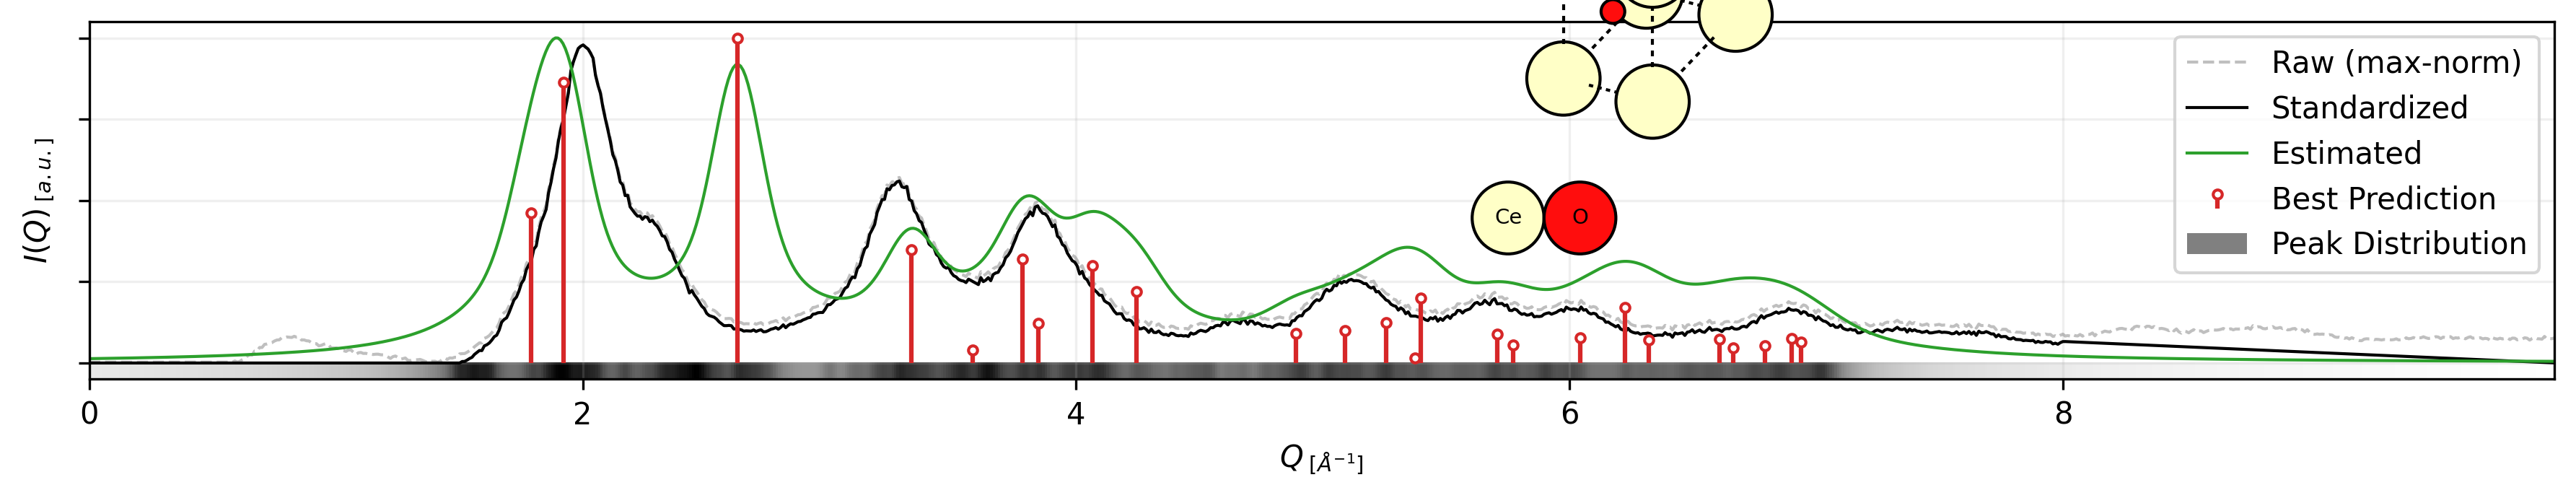

In [18]:
# Plot the best generation result using your existing plotting function
plot_pxrd_and_structure(
    df_processed_ID5['Q'], df_processed_ID5['intensity_norm'],
    df_processed_ID5['Q'], df_processed_ID5['intensity_crop_norm'],
    predictions_array_prot1_ID5,
    best_generation_prot1_ID5["pxrd_out"],
    best_generation_prot1_ID5["struct"],
    atom_radii=0.5, 
    atom_offset=(0, 2, 0),
    atom_legend_radius=1.0,
    struc_offset_x=0.1,
    struc_offset_y=0.25,
    struc_scale_height=1.0,
    struc_axis_off=True,
    struc_add_axis_x = 6.0,
    figsize=(10*1.2,2*1.2),
    dpi=300,
);

In [245]:
# Run the experiment protocol
best_generation_prot2, results_prot2, predictions_array_prot2 = run_experiment_protocol(
    model=model,
    cond_array=df_processed_ID5["intensity_crop_norm"].values,
    exp_q=df_processed_ID5["Q"].values,
    exp_i=df_processed_ID5["intensity_crop_norm"].values,
    n_trials=25,  # Set to 25 for full-scale experiments
    composition="Ce4O8",
    # spacegroup="Fm-3m_sg",
    size_estimate=7,
    complexity_weight=0.1
)

Trial 1/25 -> rwp: 0.5574, n_peaks: 231, ranking_score: 23.6574
Trial 2/25 -> rwp: 0.6610, n_peaks: 249, ranking_score: 25.5610
Trial 3/25 -> rwp: 0.8386, n_peaks: 261, ranking_score: 26.9386
Trial 4/25 -> rwp: 0.6719, n_peaks: 236, ranking_score: 24.2719
Trial 5/25 -> rwp: 0.6667, n_peaks: 247, ranking_score: 25.3667
Trial 6/25 -> rwp: 0.8958, n_peaks: 221, ranking_score: 22.9958
Trial 7/25 -> rwp: 0.7730, n_peaks: 261, ranking_score: 26.8730


KeyboardInterrupt: 

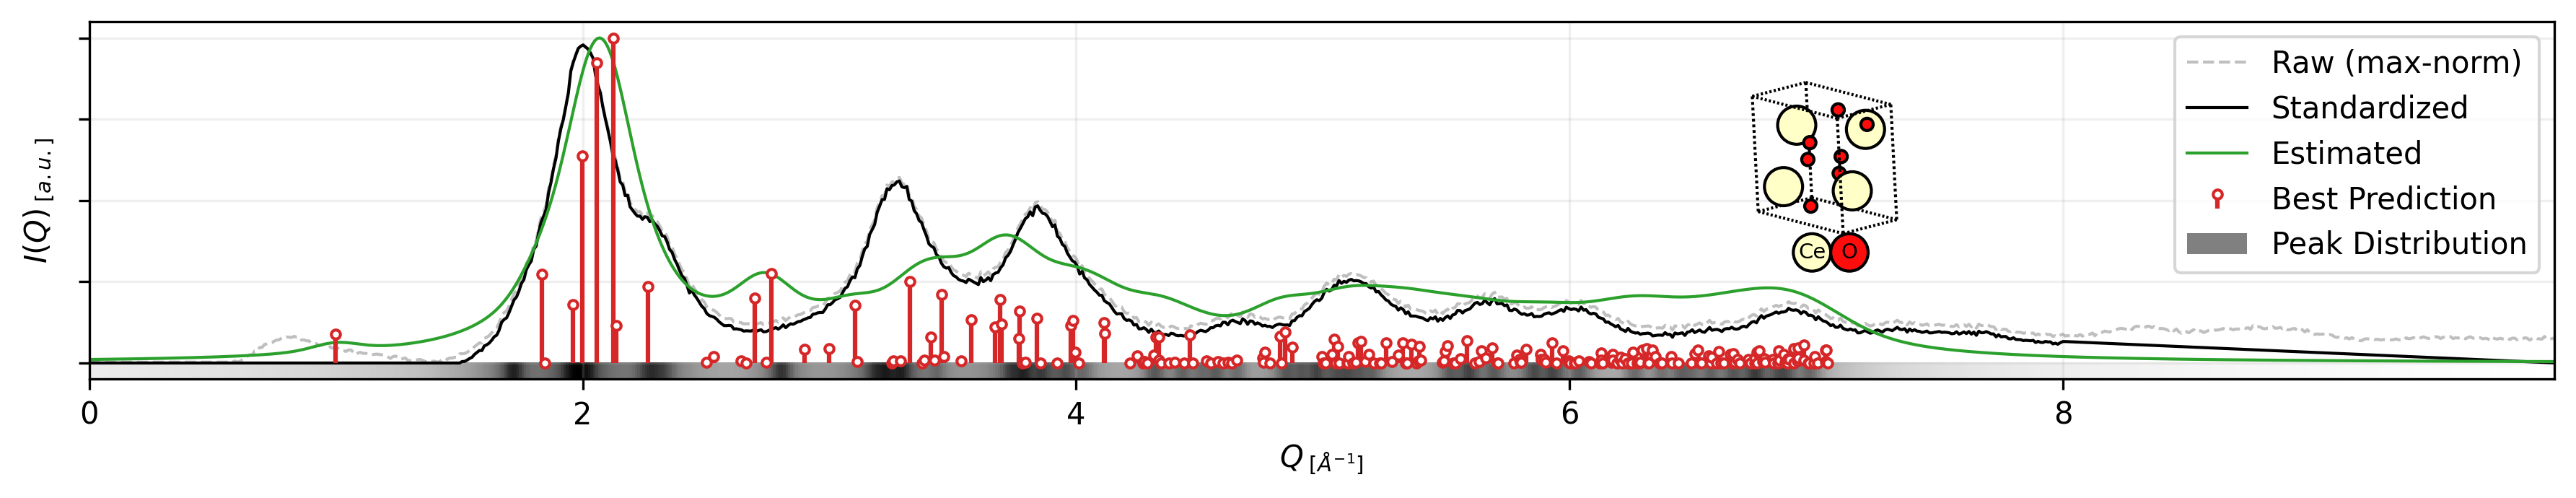

In [235]:
# Plot the best generation result using your existing plotting function
plot_pxrd_and_structure(
    df_processed_ID5['Q'], df_processed_ID5['intensity_norm'],
    df_processed_ID5['Q'], df_processed_ID5['intensity_crop_norm'],
    predictions_array_prot2,
    best_generation_prot2["pxrd_out"],
    best_generation_prot2["struct"],
    atom_radii=0.5, 
    atom_offset=(0, 2, 0),
    atom_legend_radius=1.0,
    struc_offset_x=0.2,
    struc_offset_y=0.25,
    struc_scale_height=1.0,
    struc_axis_off=True,
    struc_add_axis_x = 6.0,
    figsize=(10*1.2,2*1.2),
    dpi=300,
);

In [192]:
# Run the experiment protocol
best_generation_prot3, results_prot3, predictions_array_prot3 = run_experiment_protocol(
    model=model,
    cond_array=df_processed_ID5["intensity_crop_norm"].values,
    exp_q=df_processed_ID5["Q"].values,
    exp_i=df_processed_ID5["intensity_crop_norm"].values,
    n_trials=10,  # Set to 25 for full-scale experiments
    composition="Ce4O8",
    spacegroup="Fm-3m_sg",
    size_estimate=7,
)

Trial 1/10 -> rwp: 0.7394, n_peaks: 9, ranking_score: 0.8294
Trial 2/10 -> rwp: 0.5389, n_peaks: 8, ranking_score: 0.6189
Trial 3/10 -> rwp: 0.3753, n_peaks: 8, ranking_score: 0.4553
Trial 4/10 -> rwp: 0.3786, n_peaks: 8, ranking_score: 0.4586
Trial 5/10 -> rwp: 0.2262, n_peaks: 9, ranking_score: 0.3162
Trial 6/10 -> rwp: 0.3607, n_peaks: 8, ranking_score: 0.4407
Trial 7/10 -> rwp: 0.3602, n_peaks: 8, ranking_score: 0.4402
Trial 8/10 -> rwp: 0.8874, n_peaks: 10, ranking_score: 0.9874
Trial 9/10 -> rwp: 0.3811, n_peaks: 8, ranking_score: 0.4611
Trial 10/10 -> rwp: 0.2454, n_peaks: 8, ranking_score: 0.3254


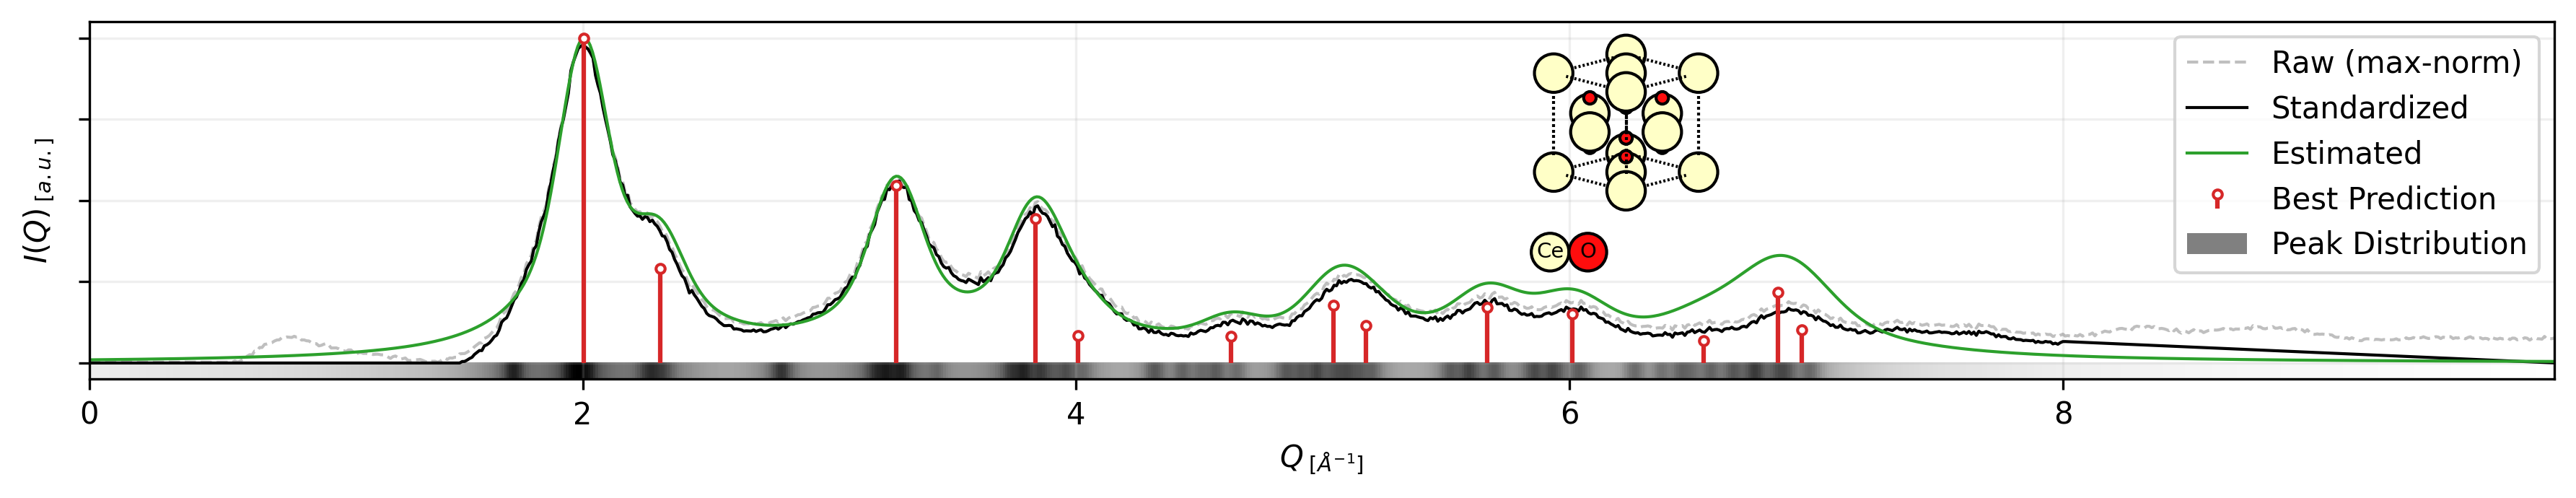

In [193]:
# Plot the best generation result using your existing plotting function
plot_pxrd_and_structure(
    df_processed_ID5['Q'], df_processed_ID5['intensity_norm'],
    df_processed_ID5['Q'], df_processed_ID5['intensity_crop_norm'],
    predictions_array_prot3,
    best_generation_prot3["pxrd_out"],
    best_generation_prot3["struct"],
    atom_radii=0.5, 
    atom_offset=(0, 2, 0),
    atom_legend_radius=1.0,
    struc_offset_x=0.1,
    struc_offset_y=0.25,
    struc_scale_height=0.75,
    struc_axis_off=True,
    struc_add_axis_x = 6.0,
    figsize=(10*1.2,2*1.2),
    dpi=300,
);

#### Hydrolyse_ID6_20min_3-56_boro_0p8.xy, CeO2, Empyrean (0.5594075 Å)

In [211]:
target_file = 'Hydrolyse_ID6_20min_3-56_boro_0p8.xy'
background_file = 'boroglass_0p8_empty_VCT_72h.xy'

df_processed_ID6 = preprocess_generic(
    df_all,
    target_file=target_file,
    background_file=background_file,
    wavelength=0.5594075,
    q_min_crop=1.5, 
    q_max_crop=8.0
)

# Run the experiment protocol
best_generation_prot1_ID6, results_prot1_ID6, predictions_array_prot1_ID6 = run_experiment_protocol(
    model=model,
    cond_array=df_processed_prot1_ID6["intensity_crop_norm"].values, 
    exp_q=df_processed_prot1_ID6["Q"].values,
    exp_i=df_processed_prot1_ID6["intensity_crop_norm"].values,
    n_trials=15,  # Set to 25 for full-scale experiments
    # composition="Ce4O8",
    # spacegroup="Fm-3m_sg"
    size_estimate = 7,
    max_new_tokens=1200,
    complexity_weight=0.5,
)

Trial 1/15 -> rwp: 0.4992, n_peaks: 9, ranking_score: 4.9992
Trial 2/15 -> rwp: 0.6580, n_peaks: 6, ranking_score: 3.6580
Trial 3/15 -> rwp: 0.8476, n_peaks: 11, ranking_score: 6.3476
Trial 4/15 -> rwp: 0.7843, n_peaks: 10, ranking_score: 5.7843
Trial 5/15 -> rwp: 0.7864, n_peaks: 10, ranking_score: 5.7864
Trial 6/15 -> rwp: 0.5963, n_peaks: 8, ranking_score: 4.5963
Trial 7/15 -> rwp: 0.8599, n_peaks: 12, ranking_score: 6.8599
Trial 8/15 -> rwp: 0.6235, n_peaks: 9, ranking_score: 5.1235
Trial 9/15 -> rwp: 0.6179, n_peaks: 8, ranking_score: 4.6179
Trial 10/15 -> rwp: 0.9095, n_peaks: 10, ranking_score: 5.9095
Trial 11/15 -> rwp: 0.7920, n_peaks: 9, ranking_score: 5.2920
Trial 12/15 -> rwp: 0.9596, n_peaks: 8, ranking_score: 4.9596
Trial 13/15 -> rwp: 0.5952, n_peaks: 8, ranking_score: 4.5952
Trial 14/15 -> rwp: 1.0216, n_peaks: 9, ranking_score: 5.5216
Trial 15/15 -> rwp: 0.7694, n_peaks: 10, ranking_score: 5.7694


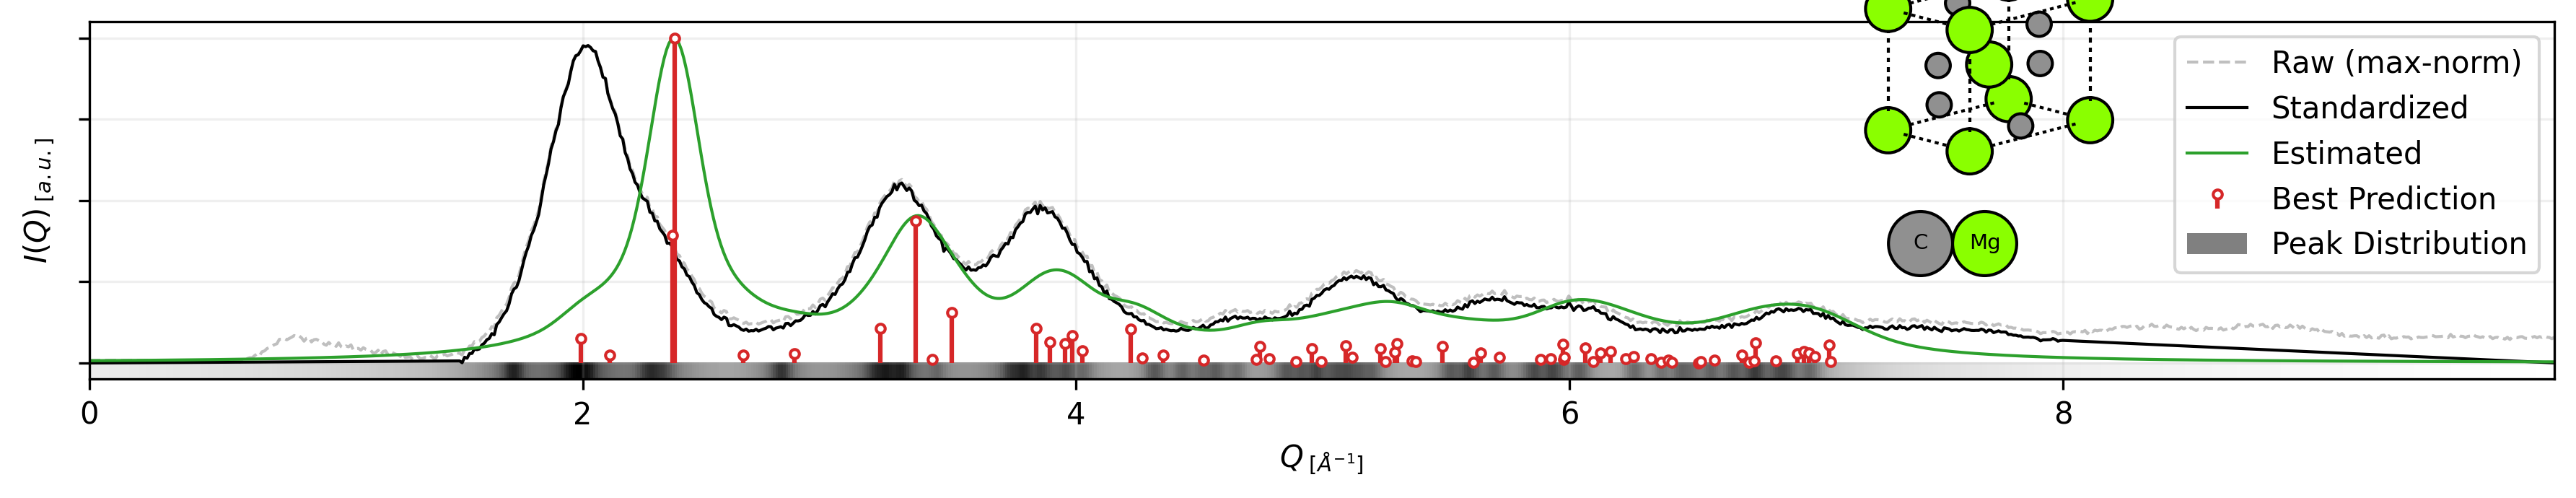

In [212]:
# Plot the best generation result using your existing plotting function
plot_pxrd_and_structure(
    df_processed_ID6['Q'], df_processed_ID6['intensity_norm'],
    df_processed_ID6['Q'], df_processed_ID6['intensity_crop_norm'],
    predictions_array_prot1_ID6,
    best_generation_prot1_ID6["pxrd_out"],
    best_generation_prot1_ID6["struct"],
    atom_radii=0.5, 
    atom_offset=(0, 2, 0),
    atom_legend_radius=1.0,
    struc_offset_x=0.25,
    struc_offset_y=0.2,
    struc_scale_height=1.5,
    struc_axis_off=True,
    struc_add_axis_x = 6.0,
    figsize=(10*1.2,2*1.2),
    dpi=300,
);

In [215]:
# Run the experiment protocol
best_generation_prot2_ID6, results_prot2_ID6, predictions_array_prot2_ID6 = run_experiment_protocol(
    model=model,
    cond_array=df_processed_ID6["intensity_crop_norm"].values, 
    exp_q=df_processed_ID6["Q"].values,
    exp_i=df_processed_ID6["intensity_crop_norm"].values,
    n_trials=5,  # Set to 25 for full-scale experiments
    composition="Ce4O8",
    # spacegroup="Fm-3m_sg",
    size_estimate = 7,
    max_new_tokens = 1500,
    complexity_weight=1.09,
)

Trial 1/5 -> rwp: 0.6103, n_peaks: 12, ranking_score: 13.6903
Trial 2/5 -> rwp: 1.0091, n_peaks: 10, ranking_score: 11.9091
Trial 3/5 -> rwp: 0.5421, n_peaks: 9, ranking_score: 10.3521
Trial 4/5 -> rwp: 1.0526, n_peaks: 8, ranking_score: 9.7726
Trial 5/5 -> rwp: 0.4855, n_peaks: 8, ranking_score: 9.2055


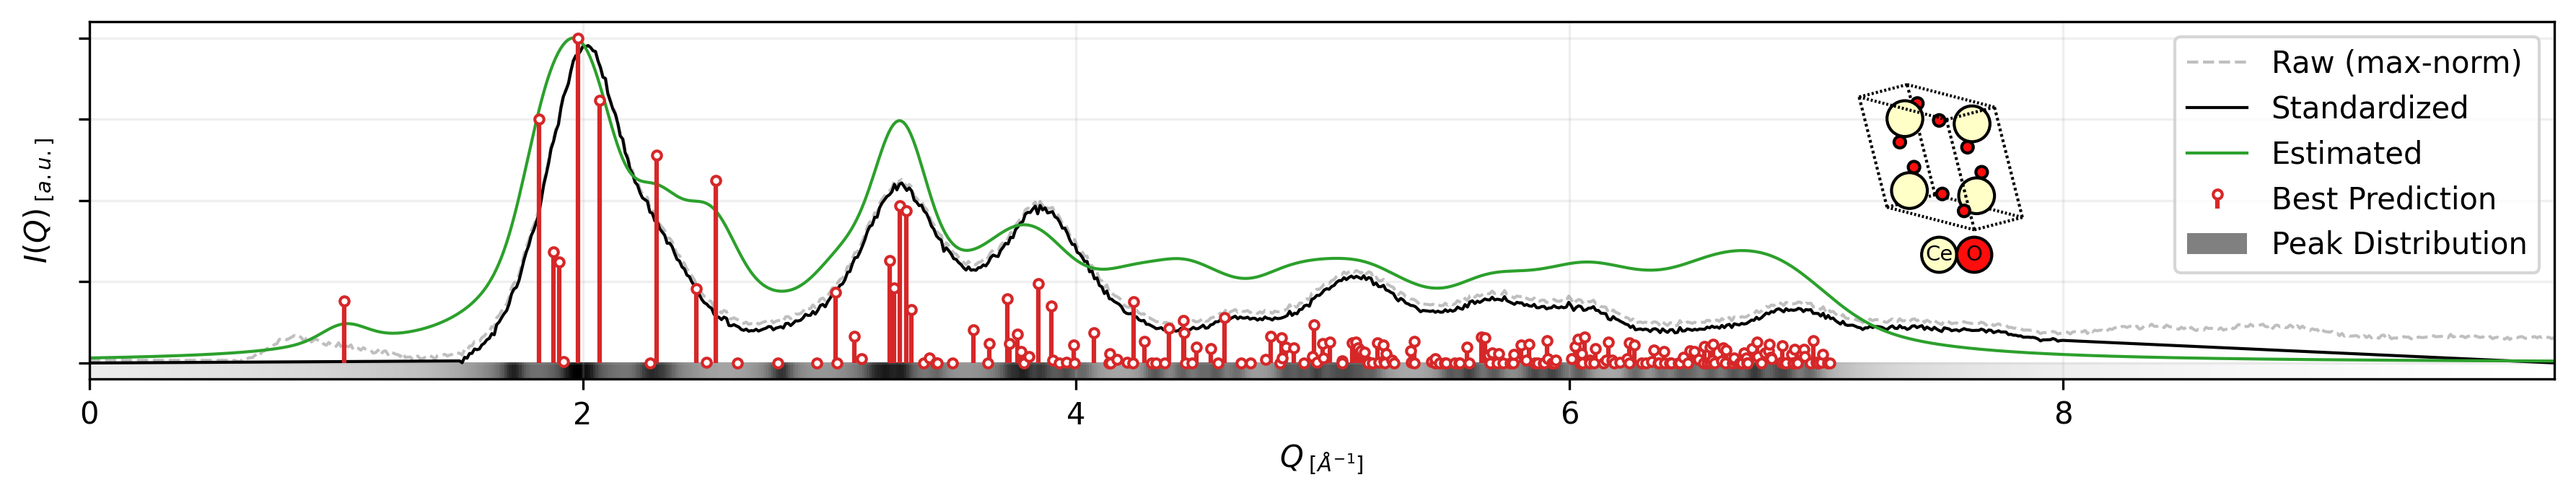

In [216]:
# Plot the best generation result using your existing plotting function
plot_pxrd_and_structure(
    df_processed_ID6['Q'], df_processed_ID6['intensity_norm'],
    df_processed_ID6['Q'], df_processed_ID6['intensity_crop_norm'],
    predictions_array_prot2_ID6,
    best_generation_prot2_ID6["pxrd_out"],
    best_generation_prot2_ID6["struct"],
    atom_radii=0.5, 
    atom_offset=(0, 2, 0),
    atom_legend_radius=1.0,
    struc_offset_x=0.25,
    struc_offset_y=0.25,
    struc_scale_height=1.0,
    struc_axis_off=True,
    struc_add_axis_x = 6.0,
    figsize=(10*1.2,2*1.2),
    dpi=300,
);